In [12]:

! pip install langchain langchain-community langchain-huggingface langgraph
! pip install networkx python-dotenv
! pip install ragas datasets matplotlib numpy
! pip install pypdf sentence-transformers


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import uuid
import json
import re
import dotenv
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from typing import List, Dict, Any, TypedDict, Annotated, Optional
from dataclasses import dataclass, field

# LangChain
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.documents import Document

# LangGraph
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

# Anthropic via LangChain
from langchain.chat_models import init_chat_model

# RAGAS
from transformers import logging as hf_logging
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall

hf_logging.set_verbosity_error()

c:\Users\igors\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\igors\AppData\Local\Temp\ipykernel_37908\1128622841.py:36: DeprecationWarning: Importing faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import faithfulness
  from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall
C:\Users\igors\AppData\Local\Temp\ipykernel_37908\1128622841.py:36: DeprecationWarning: Importing answer_relevancy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import answer_relevancy
  from ragas.metrics import faithfulness, answer_relev

In [ ]:
dotenv.load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_BASE_URL"] = os.getenv("OPEN_API_URL", "https://inference.do-ai.run/v1")

os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

os.environ["LANGCHAIN_TRACING_V2"] = os.getenv("LANGCHAIN_TRACING_V2", "true")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT", "rag-sael")

✅ Variáveis de ambiente carregadas
   LangSmith Project: rag-sael
   Tracing ativo: true


In [ ]:
llm = init_chat_model(
    model=os.getenv("OPEN_MODEL", "openai-gpt-oss-120b"),
    model_provider="openai",
    base_url=os.getenv("OPEN_API_URL", "https://inference.do-ai.run/v1"),
)

llm_extractor = init_chat_model(
    model=os.getenv("OPEN_MODEL", "openai-gpt-oss-120b"),
    model_provider="openai",
    base_url=os.getenv("OPEN_API_URL", "https://inference.do-ai.run/v1"),
)


✅ Modelos carregados: openai-gpt-oss-120b


In [ ]:
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

vector_store = InMemoryVectorStore(embeddings)

✅ HuggingFace Embeddings carregado: all-MiniLM-L6-v2
✅ InMemoryVectorStore inicializado


In [ ]:
@dataclass
class EntityNode:
    """Representa uma entidade no grafo de conhecimento."""
    id: str
    name: str
    type: str            # Person, Organization, Concept, Location, Event
    description: str = ""
    chunk_ids: List[str] = field(default_factory=list)

@dataclass
class RelationEdge:
    """Representa uma relação entre duas entidades."""
    source_id: str
    target_id: str
    relation_type: str   # RELATES_TO, IS_A, PART_OF, CAUSES, etc.
    description: str = ""
    weight: float = 1.0


class KnowledgeGraph:
    """Grafo de conhecimento baseado em NetworkX com busca por entidade e subgrafo."""

    def __init__(self):
        self.graph = nx.DiGraph()
        self.entities: Dict[str, EntityNode] = {}
        self._name_index: Dict[str, str] = {}   # name.lower() → entity_id

    # ── Inserção ──────────────────────────────────────────────────────────────

    def add_entity(self, entity: EntityNode) -> None:
        self.entities[entity.id] = entity
        self._name_index[entity.name.lower()] = entity.id
        self.graph.add_node(
            entity.id,
            name=entity.name,
            type=entity.type,
            description=entity.description,
        )

    def add_relation(self, relation: RelationEdge) -> None:
        if relation.source_id in self.entities and relation.target_id in self.entities:
            self.graph.add_edge(
                relation.source_id,
                relation.target_id,
                relation=relation.relation_type,
                description=relation.description,
                weight=relation.weight,
            )

    # ── Busca ─────────────────────────────────────────────────────────────────

    def find_entity_by_name(self, name: str) -> Optional[EntityNode]:
        """Busca entidade por nome (case-insensitive, correspondência parcial)."""
        name_lower = name.lower()
        # Correspondência exata
        if name_lower in self._name_index:
            return self.entities[self._name_index[name_lower]]
        # Correspondência parcial
        for stored_name, eid in self._name_index.items():
            if name_lower in stored_name or stored_name in name_lower:
                return self.entities[eid]
        return None

    def get_neighbors(self, entity_id: str, depth: int = 2) -> List[str]:
        """Retorna IDs de vizinhos até profundidade N via BFS."""
        visited = set()
        frontier = {entity_id}
        for _ in range(depth):
            next_frontier = set()
            for nid in frontier:
                nbrs = set(self.graph.successors(nid)) | set(self.graph.predecessors(nid))
                next_frontier.update(nbrs - visited)
            visited.update(frontier)
            frontier = next_frontier
        visited.update(frontier)
        return list(visited)

    def build_context(self, node_ids: List[str]) -> str:
        """Converte subgrafo em texto estruturado para o LLM."""
        if not node_ids:
            return "Nenhuma entidade relevante encontrada no grafo."

        subgraph = self.graph.subgraph(node_ids)
        lines = ["### Entidades Relevantes do Grafo\n"]

        for nid in subgraph.nodes():
            entity = self.entities.get(nid)
            if entity:
                lines.append(f"- **{entity.name}** [{entity.type}]: {entity.description}")

        lines.append("\n### Relações\n")
        for u, v, data in subgraph.edges(data=True):
            u_name = self.entities.get(u, EntityNode(u, u, "")).name
            v_name = self.entities.get(v, EntityNode(v, v, "")).name
            rel = data.get("relation", "RELATES_TO")
            desc = data.get("description", "")
            lines.append(f"- {u_name} --[{rel}]--> {v_name}: {desc}")

        return "\n".join(lines)

    @property
    def stats(self) -> Dict[str, int]:
        return {
            "nodes": self.graph.number_of_nodes(),
            "edges": self.graph.number_of_edges(),
        }

knowledge_graph = KnowledgeGraph()

✅ KnowledgeGraph inicializado


In [ ]:
loader = DirectoryLoader(
    path="docs",
    glob="**/*.pdf",
    loader_cls=PyPDFLoader
)

docs = loader.load()
print(f"✅ {len(docs)} páginas carregadas")

✅ 41 páginas carregadas


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True
)

all_splits = text_splitter.split_documents(docs)

for i, split in enumerate(all_splits):
    split.metadata["chunk_id"] = f"chunk_{i}"

# Indexa no vector store (mesmo do agent_rag)
document_ids = vector_store.add_documents(documents=all_splits)

print(f"✅ {len(all_splits)} chunks criados e indexados no vector store")

✅ 81 chunks criados e indexados no vector store


In [ ]:
EXTRACTION_SYSTEM = """Você é um extrator especializado de entidades e relações.
Retorne APENAS um JSON válido, sem texto adicional, sem markdown."""

EXTRACTION_TEMPLATE = """Analise o texto e extraia entidades e relações.

Retorne SOMENTE este JSON (sem blocos de código, sem explicações):
{{
  "entities": [
    {{"id": "e1", "name": "Nome da Entidade", "type": "Concept|Person|Organization|Location|Event", "description": "descrição breve"}}
  ],
  "relations": [
    {{"source": "e1", "target": "e2", "type": "RELATES_TO|IS_A|PART_OF|CAUSES|DEFINES", "description": "como se relacionam"}}
  ]
}}

Texto:
{text}"""


def extract_entities_from_chunk(chunk: Document) -> Dict:
    """Chama Claude para extrair entidades e relações de um chunk."""
    prompt = EXTRACTION_TEMPLATE.format(text=chunk.page_content[:1500])
    messages = [
        SystemMessage(content=EXTRACTION_SYSTEM),
        HumanMessage(content=prompt),
    ]
    response = llm_extractor.invoke(messages)
    raw = response.content.strip()

    # Remove blocos de código se o modelo incluir por engano
    raw = re.sub(r"```(?:json)?\s*", "", raw).strip().rstrip("`")

    try:
        return json.loads(raw)
    except json.JSONDecodeError:
        return {"entities": [], "relations": []}


def ingest_chunk_into_graph(chunk: Document, extraction: Dict) -> None:
    """Adiciona entidades e relações extraídas ao grafo de conhecimento."""
    chunk_id = chunk.metadata.get("chunk_id", str(uuid.uuid4()))
    local_id_map: Dict[str, str] = {}  # id local do JSON → id global no grafo

    # Adiciona entidades
    for ent in extraction.get("entities", []):
        global_id = f"{ent['name'].lower().replace(' ', '_')}_{ent['type'].lower()}"
        local_id_map[ent["id"]] = global_id

        if global_id not in knowledge_graph.entities:
            knowledge_graph.add_entity(EntityNode(
                id=global_id,
                name=ent["name"],
                type=ent.get("type", "Concept"),
                description=ent.get("description", ""),
                chunk_ids=[chunk_id],
            ))
        else:
            # Entidade já existe — apenas registra o chunk
            knowledge_graph.entities[global_id].chunk_ids.append(chunk_id)

    for rel in extraction.get("relations", []):
        src = local_id_map.get(rel["source"])
        tgt = local_id_map.get(rel["target"])
        if src and tgt:
            knowledge_graph.add_relation(RelationEdge(
                source_id=src,
                target_id=tgt,
                relation_type=rel.get("type", "RELATES_TO"),
                description=rel.get("description", ""),
            ))

✅ Funções de extração definidas


In [ ]:
MAX_CHUNKS_TO_EXTRACT = min(len(all_splits), 20)

for i, chunk in enumerate(all_splits[:MAX_CHUNKS_TO_EXTRACT]):
    print(f"  [{i+1}/{MAX_CHUNKS_TO_EXTRACT}] Chunk {chunk.metadata.get('chunk_id')}...", end=" ")
    extraction = extract_entities_from_chunk(chunk)
    ingest_chunk_into_graph(chunk, extraction)
    n_ents = len(extraction.get("entities", []))
    n_rels = len(extraction.get("relations", []))
    print(f"{n_ents} entidades, {n_rels} relações")

stats = knowledge_graph.stats
print(f"\nGrafo construído: {stats['nodes']} nós | {stats['edges']} arestas")

Extraindo entidades de 20 chunks via Claude...

  [1/20] Chunk chunk_0... 6 entidades, 5 relações
  [2/20] Chunk chunk_1... 10 entidades, 10 relações
  [3/20] Chunk chunk_2... 9 entidades, 8 relações
  [4/20] Chunk chunk_3... 11 entidades, 8 relações
  [5/20] Chunk chunk_4... 8 entidades, 6 relações
  [6/20] Chunk chunk_5... 10 entidades, 8 relações
  [7/20] Chunk chunk_6... 7 entidades, 3 relações
  [8/20] Chunk chunk_7... 2 entidades, 0 relações
  [9/20] Chunk chunk_8... 13 entidades, 10 relações
  [10/20] Chunk chunk_9... 23 entidades, 18 relações
  [11/20] Chunk chunk_10... 11 entidades, 11 relações
  [12/20] Chunk chunk_11... 8 entidades, 6 relações
  [13/20] Chunk chunk_12... 7 entidades, 6 relações
  [14/20] Chunk chunk_13... 8 entidades, 7 relações
  [15/20] Chunk chunk_14... 18 entidades, 17 relações
  [16/20] Chunk chunk_15... 12 entidades, 13 relações
  [17/20] Chunk chunk_16... 6 entidades, 5 relações
  [18/20] Chunk chunk_17... 9 entidades, 12 relações
  [19/20] Chunk chun

In [ ]:
@tool(response_format="content_and_artifact")
def retrieve_vector_context(query: str):
    """Recupera chunks de texto relevantes por similaridade semântica."""
    retrieved_docs = vector_store.similarity_search(query, k=3)
    serialized = "\n\n".join(
        f"Source: {doc.metadata}\nContent: {doc.page_content}"
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


@tool(response_format="content_and_artifact")
def retrieve_graph_context(query: str):
    """Recupera contexto estruturado do grafo de conhecimento: entidades e relações relevantes à query."""
    # Identifica palavras-chave na query para entity linking
    words = [w.strip('.,;:?!"') for w in query.split() if len(w) > 3]

    relevant_nodes: List[str] = []
    for word in words:
        entity = knowledge_graph.find_entity_by_name(word)
        if entity:
            neighbors = knowledge_graph.get_neighbors(entity.id, depth=2)
            relevant_nodes.extend(neighbors)

    # Deduplica e limita
    relevant_nodes = list(set(relevant_nodes))[:40]

    graph_context = knowledge_graph.build_context(relevant_nodes)
    return graph_context, relevant_nodes


tools = [retrieve_vector_context, retrieve_graph_context]
print("Tools registrados:", [t.name for t in tools])

✅ Tools registrados: ['retrieve_vector_context', 'retrieve_graph_context']


In [ ]:
class GraphRAGState(TypedDict):
    messages: Annotated[list, add_messages]


SYSTEM_PROMPT = """Você é um assistente especializado em análise de documentos com acesso a um grafo de conhecimento.

Você possui DOIS tools:
1. retrieve_graph_context — recupera entidades e relações estruturadas do grafo de conhecimento
2. retrieve_vector_context — recupera trechos de texto por similaridade semântica

Para responder bem:
- Sempre use retrieve_graph_context primeiro para entender as relações entre conceitos
- Use retrieve_vector_context para obter detalhes textuais complementares
- Integre ambas as fontes na sua resposta
- Cite explicitamente quais entidades e relações do grafo embasam sua resposta
- Responda sempre em português, mesmo que a pergunta seja em outro idioma"""


llm_with_tools = llm.bind_tools(tools)


def agent_node(state: GraphRAGState) -> GraphRAGState:
    """Nó do agente: Claude decide a próxima ação."""
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


def should_continue(state: GraphRAGState) -> str:
    """Roteamento: continua para tools ou encerra."""
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return END

workflow = StateGraph(GraphRAGState)
workflow.add_node("agent", agent_node)
workflow.add_node("tools", ToolNode(tools))

workflow.set_entry_point("agent")
workflow.add_conditional_edges("agent", should_continue, {"tools": "tools", END: END})
workflow.add_edge("tools", "agent")

checkpointer = MemorySaver()
agent = workflow.compile(checkpointer=checkpointer)

print("Agente LangGraph compilado")
print("   Fluxo: agent → [tools → agent]* → END")

✅ Agente LangGraph compilado
   Fluxo: agent → [tools → agent]* → END


In [ ]:
def query_graph_rag(question: str, thread_id: Optional[str] = None) -> Dict[str, Any]:
    """Executa uma query no agente Graph RAG e retorna a resposta com metadados."""
    if thread_id is None:
        thread_id = str(uuid.uuid4())

    events = list(agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        config={"configurable": {"thread_id": thread_id}},
        stream_mode="values",
    ))

    final_event = events[-1]
    answer = final_event["messages"][-1].content

    # Coleta contextos para avaliação RAGAS
    retrieved_docs = vector_store.similarity_search(question, k=3)
    contexts = [doc.page_content for doc in retrieved_docs]

    return {
        "question": question,
        "answer": answer,
        "contexts": contexts,
        "thread_id": thread_id,
    }

test_question = "O que é lógica proposicional?"
print(f"Pergunta: {test_question}\n")

result = query_graph_rag(test_question)
print("Resposta do Graph RAG:")
print("-" * 60)
print(result["answer"])

Pergunta: O que é lógica proposicional?

Resposta do Graph RAG:
------------------------------------------------------------
**Lógica proposicional** (ou lógica sentencial) é a parte da lógica que se ocupa do estudo formal das **proposições** – frases que podem ser classificadas como **verdadeiras (V)** ou **falsas (F)** – e das formas de combiná‑las por meio de **conectivos lógicos** para produzir novas proposições.  

---

### Principais componentes (extraídos do grafo de conhecimento)

| Entidade | Papel na lógica proposicional |
|----------|-------------------------------|
| **Proposição simples** (`P`, `Q`, `R`) – *é uma proposição que não contém outra proposição como parte integrante*【graph:Proposição simples】 | Unidade básica da lógica proposicional. Cada proposição simples tem um **valor lógico** (`V` ou `F`). |
| **Conectivo lógico** – *palavras ou símbolos que são usados para formar novas proposições a partir de outras*【graph:Conectivo lógico】 | Operadores que permitem combin

In [ ]:
test_queries = [
    "O que é lógica proposicional segundo a apostila?",
    "Como a apostila define uma proposição?",
    "O que são conectivos lógicos e quais são apresentados no material?",
    "O que é uma tabela-verdade e para que ela é utilizada?",
    "Como a apostila define tautologia, contradição e contingência?"
]

ground_truths = [
    "Lógica proposicional é o ramo da lógica que estuda proposições e as relações entre elas por meio de conectivos lógicos.",
    "Proposição é toda sentença declarativa que pode ser classificada como verdadeira ou falsa, mas não ambas.",
    "Conectivos lógicos são operadores que conectam proposições, como negação (¬), conjunção (∧), disjunção (∨), condicional (→) e bicondicional (↔).",
    "Tabela-verdade é um método utilizado para determinar o valor lógico de proposições compostas a partir dos valores lógicos das proposições simples.",
    "Tautologia é uma proposição composta que é sempre verdadeira; contradição é sempre falsa; contingência é aquela que pode ser verdadeira ou falsa dependendo dos valores das proposições componentes."
]

print(f"{len(test_queries)} queries de avaliação configuradas")

✅ 5 queries de avaliação configuradas


In [ ]:
def run_graph_rag_evaluation() -> Any:
    """Executa o agente Graph RAG nas queries de teste e avalia com RAGAS."""
    print("Executando Graph RAG agent para coletar dados de teste...\n")
    ragas_data = []

    for i, query in enumerate(test_queries):
        print(f"  [{i+1}/{len(test_queries)}] {query}")
        result = query_graph_rag(query)
        ragas_data.append({
            "question": result["question"],
            "contexts": result["contexts"],
            "answer": result["answer"],
            "ground_truth": ground_truths[i],
        })

    test_dataset = Dataset.from_list(ragas_data)

    print("\nExecutando avaliação RAGAS...")

    eval_llm = init_chat_model(
        model=os.getenv("OPEN_MODEL", "openai-gpt-oss-120b"),
        model_provider="openai",
        base_url=os.getenv("OPEN_API_URL", "https://inference.do-ai.run/v1"),
    )

    result = evaluate(
        test_dataset,
        metrics=[faithfulness, answer_relevancy, context_precision, context_recall],
        llm=eval_llm,
        embeddings=embeddings,
    )

    print("\n=== RESULTADOS RAGAS — Graph RAG com Claude ===")
    print(result)

    df = result.to_pandas()
    print("\nDetalhes por query:")
    print(df.to_string())

    return result


ragas_result = run_graph_rag_evaluation()


Executando Graph RAG agent para coletar dados de teste...

  [1/5] O que é lógica proposicional segundo a apostila?
  [2/5] Como a apostila define uma proposição?
  [3/5] O que são conectivos lógicos e quais são apresentados no material?
  [4/5] O que é uma tabela-verdade e para que ela é utilizada?
  [5/5] Como a apostila define tautologia, contradição e contingência?

Executando avaliação RAGAS...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 20/20 [01:07<00:00,  3.35s/it]



=== RESULTADOS RAGAS — Graph RAG com Claude ===
{'faithfulness': 0.4598, 'answer_relevancy': 0.4059, 'context_precision': 0.7833, 'context_recall': 1.0000}

Detalhes por query:
                                                           user_input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [15]:
df_results = ragas_result.to_pandas()

metrics = ["faithfulness", "answer_relevancy", "context_precision", "context_recall"]
metric_labels = ["Faithfulness", "Answer Relevancy", "Context Precision", "Context Recall"]
available_metrics = [m for m in metrics if m in df_results.columns]
available_labels  = [metric_labels[i] for i, m in enumerate(metrics) if m in df_results.columns]

if not available_metrics:
    raise ValueError("Nenhuma métrica esperada encontrada em df_results.")

plot_df = df_results[available_metrics].apply(lambda col: col.astype(float)).copy()
mean_scores = plot_df.mean().tolist()
n_queries   = len(plot_df)
colors      = ["#2c3e50", "#3498db", "#e74c3c", "#27ae60"][:len(available_metrics)]

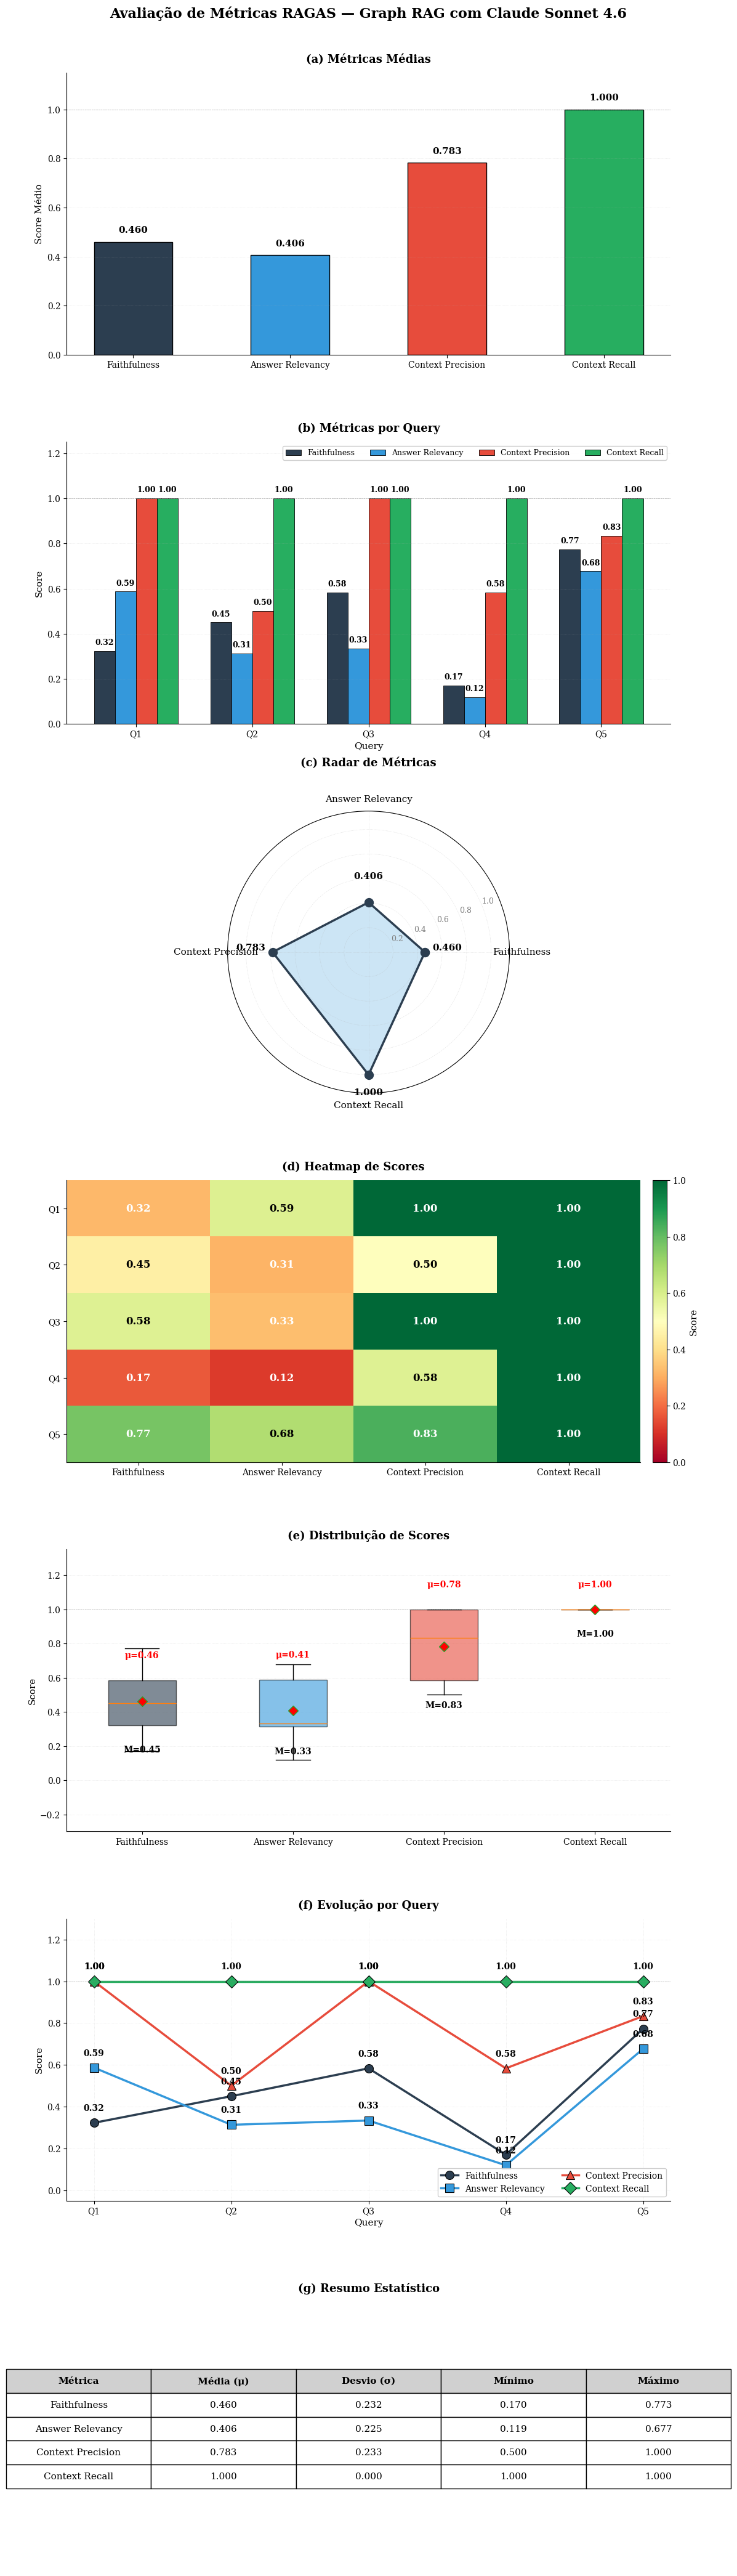

In [16]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 14,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
    "grid.linewidth": 0.5,
    "lines.linewidth": 2,
    "lines.markersize": 8,
})

fig = plt.figure(figsize=(12, 42))
fig.suptitle("Avaliação de Métricas RAGAS — Graph RAG com Claude Sonnet 4.6",
             fontsize=16, fontweight="bold", y=0.995)

x = np.arange(n_queries)

# (a) Métricas Médias
ax1 = fig.add_subplot(7, 1, 1)
bars = ax1.bar(range(len(available_metrics)), mean_scores, color=colors,
               edgecolor="black", linewidth=1, width=0.5)
ax1.set_title("(a) Métricas Médias", fontweight="bold", pad=12)
ax1.set_ylabel("Score Médio")
ax1.set_ylim(0, 1.15)
ax1.set_xticks(range(len(available_metrics)))
ax1.set_xticklabels(available_labels)
ax1.axhline(y=1.0, color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
ax1.grid(axis="y", linestyle=":", alpha=0.4)
for bar, score in zip(bars, mean_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, score + 0.03, f"{score:.3f}",
             ha="center", va="bottom", fontsize=11, fontweight="bold")

# (b) Métricas por Query
ax2 = fig.add_subplot(7, 1, 2)
width = 0.18
for i, (metric, label) in enumerate(zip(available_metrics, available_labels)):
    offset = width * i
    rects = ax2.bar(x + offset, plot_df[metric].values, width, label=label,
                    color=colors[i], edgecolor="black", linewidth=0.6)
    for rect, val in zip(rects, plot_df[metric].values):
        ax2.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.02,
                 f"{val:.2f}", ha="center", va="bottom", fontsize=9, fontweight="bold")
ax2.set_title("(b) Métricas por Query", fontweight="bold", pad=12)
ax2.set_xlabel("Query")
ax2.set_ylabel("Score")
ax2.set_xticks(x + width * (len(available_metrics) - 1) / 2)
ax2.set_xticklabels([f"Q{i+1}" for i in range(n_queries)])
ax2.set_ylim(0, 1.25)
ax2.axhline(y=1.0, color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
ax2.legend(loc="upper right", frameon=True, framealpha=0.95, fontsize=9, ncol=4)
ax2.grid(axis="y", linestyle=":", alpha=0.4)

# (c) Radar
ax3 = fig.add_subplot(7, 1, 3, projection="polar")
angles = np.linspace(0, 2 * np.pi, len(available_metrics), endpoint=False).tolist()
angles += angles[:1]
radar_values = mean_scores + [mean_scores[0]]
ax3.plot(angles, radar_values, color="#2c3e50", linewidth=2.5, marker="o", markersize=10)
ax3.fill(angles, radar_values, color="#3498db", alpha=0.25)
for angle, value, label in zip(angles[:-1], mean_scores, available_labels):
    ax3.annotate(f"{value:.3f}", xy=(angle, value), xytext=(angle, value + 0.18),
                 ha="center", va="bottom", fontsize=11, fontweight="bold")
ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(available_labels, fontsize=11)
ax3.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax3.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=9, color="gray")
ax3.set_ylim(0, 1.15)
ax3.set_title("(c) Radar de Métricas", fontweight="bold", pad=20, y=1.1)
ax3.grid(True, linestyle=":", alpha=0.5)

# (d) Heatmap
ax4 = fig.add_subplot(7, 1, 4)
heatmap_data = plot_df.values
im = ax4.imshow(heatmap_data, cmap="RdYlGn", aspect="auto", vmin=0, vmax=1)
ax4.set_title("(d) Heatmap de Scores", fontweight="bold", pad=12)
ax4.set_xticks(np.arange(len(available_metrics)))
ax4.set_xticklabels(available_labels)
ax4.set_yticks(np.arange(n_queries))
ax4.set_yticklabels([f"Q{i+1}" for i in range(n_queries)])
for i in range(n_queries):
    for j in range(len(available_metrics)):
        val = heatmap_data[i, j]
        text_color = "white" if val < 0.4 or val > 0.75 else "black"
        ax4.text(j, i, f"{val:.2f}", ha="center", va="center",
                 color=text_color, fontsize=12, fontweight="bold")
cbar = fig.colorbar(im, ax=ax4, fraction=0.03, pad=0.02)
cbar.set_label("Score", fontsize=11)
cbar.ax.tick_params(labelsize=10)

# (e) Boxplot
ax5 = fig.add_subplot(7, 1, 5)
box_data = [plot_df[m].dropna().values for m in available_metrics]
bp = ax5.boxplot(box_data, labels=available_labels, patch_artist=True,
                 showmeans=True, meanprops={"marker": "D", "markerfacecolor": "red", "markersize": 8})
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
    patch.set_edgecolor("black")
    patch.set_linewidth(1)
for i, data in enumerate(box_data):
    mean_val   = np.mean(data)
    median_val = np.median(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    ax5.text(i + 1, q3 + 0.12, f"μ={mean_val:.2f}",
             ha="center", va="bottom", fontsize=10, fontweight="bold", color="red")
    ax5.text(i + 1, q1 - 0.12, f"M={median_val:.2f}",
             ha="center", va="top", fontsize=10, color="black", fontweight="bold")
ax5.set_title("(e) Distribuição de Scores", fontweight="bold", pad=12)
ax5.set_ylabel("Score")
ax5.set_ylim(-0.3, 1.35)
ax5.axhline(y=1.0, color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
ax5.grid(axis="y", linestyle=":", alpha=0.4)

# (f) Evolução por Query
ax6 = fig.add_subplot(7, 1, 6)
markers = ["o", "s", "^", "D"]
for i, (metric, label) in enumerate(zip(available_metrics, available_labels)):
    ax6.plot(x, plot_df[metric], marker=markers[i], label=label,
             color=colors[i], linewidth=2.5, markersize=10,
             markeredgecolor="black", markeredgewidth=0.8)
    for xi, val in zip(x, plot_df[metric]):
        ax6.annotate(f"{val:.2f}", xy=(xi, val), xytext=(0, 12),
                     textcoords="offset points", ha="center", va="bottom",
                     fontsize=10, fontweight="bold")
ax6.set_title("(f) Evolução por Query", fontweight="bold", pad=12)
ax6.set_xlabel("Query")
ax6.set_ylabel("Score")
ax6.set_xticks(x)
ax6.set_xticklabels([f"Q{i+1}" for i in range(n_queries)])
ax6.set_ylim(-0.05, 1.3)
ax6.axhline(y=1.0, color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
ax6.legend(loc="lower right", frameon=True, framealpha=0.95, fontsize=10, ncol=2)
ax6.grid(linestyle=":", alpha=0.4)

# (g) Resumo Estatístico
ax7 = fig.add_subplot(7, 1, 7)
ax7.axis("off")
desc = plot_df.describe().loc[["mean", "std", "min", "max"]].round(3)
table_data = [["Métrica", "Média (μ)", "Desvio (σ)", "Mínimo", "Máximo"]]
for m, label in zip(available_metrics, available_labels):
    table_data.append([
        label,
        f"{desc.loc['mean', m]:.3f}",
        f"{desc.loc['std', m]:.3f}",
        f"{desc.loc['min', m]:.3f}",
        f"{desc.loc['max', m]:.3f}",
    ])
table = ax7.table(
    cellText=table_data[1:],
    colLabels=table_data[0],
    loc="center",
    cellLoc="center",
    colColours=["#f0f0f0"] * 5,
    cellColours=[["white"] * 5 for _ in range(len(available_metrics))],
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)
for i in range(5):
    table[(0, i)].set_text_props(fontweight="bold")
    table[(0, i)].set_facecolor("#d0d0d0")
ax7.set_title("(g) Resumo Estatístico", fontweight="bold", pad=12, y=0.95)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

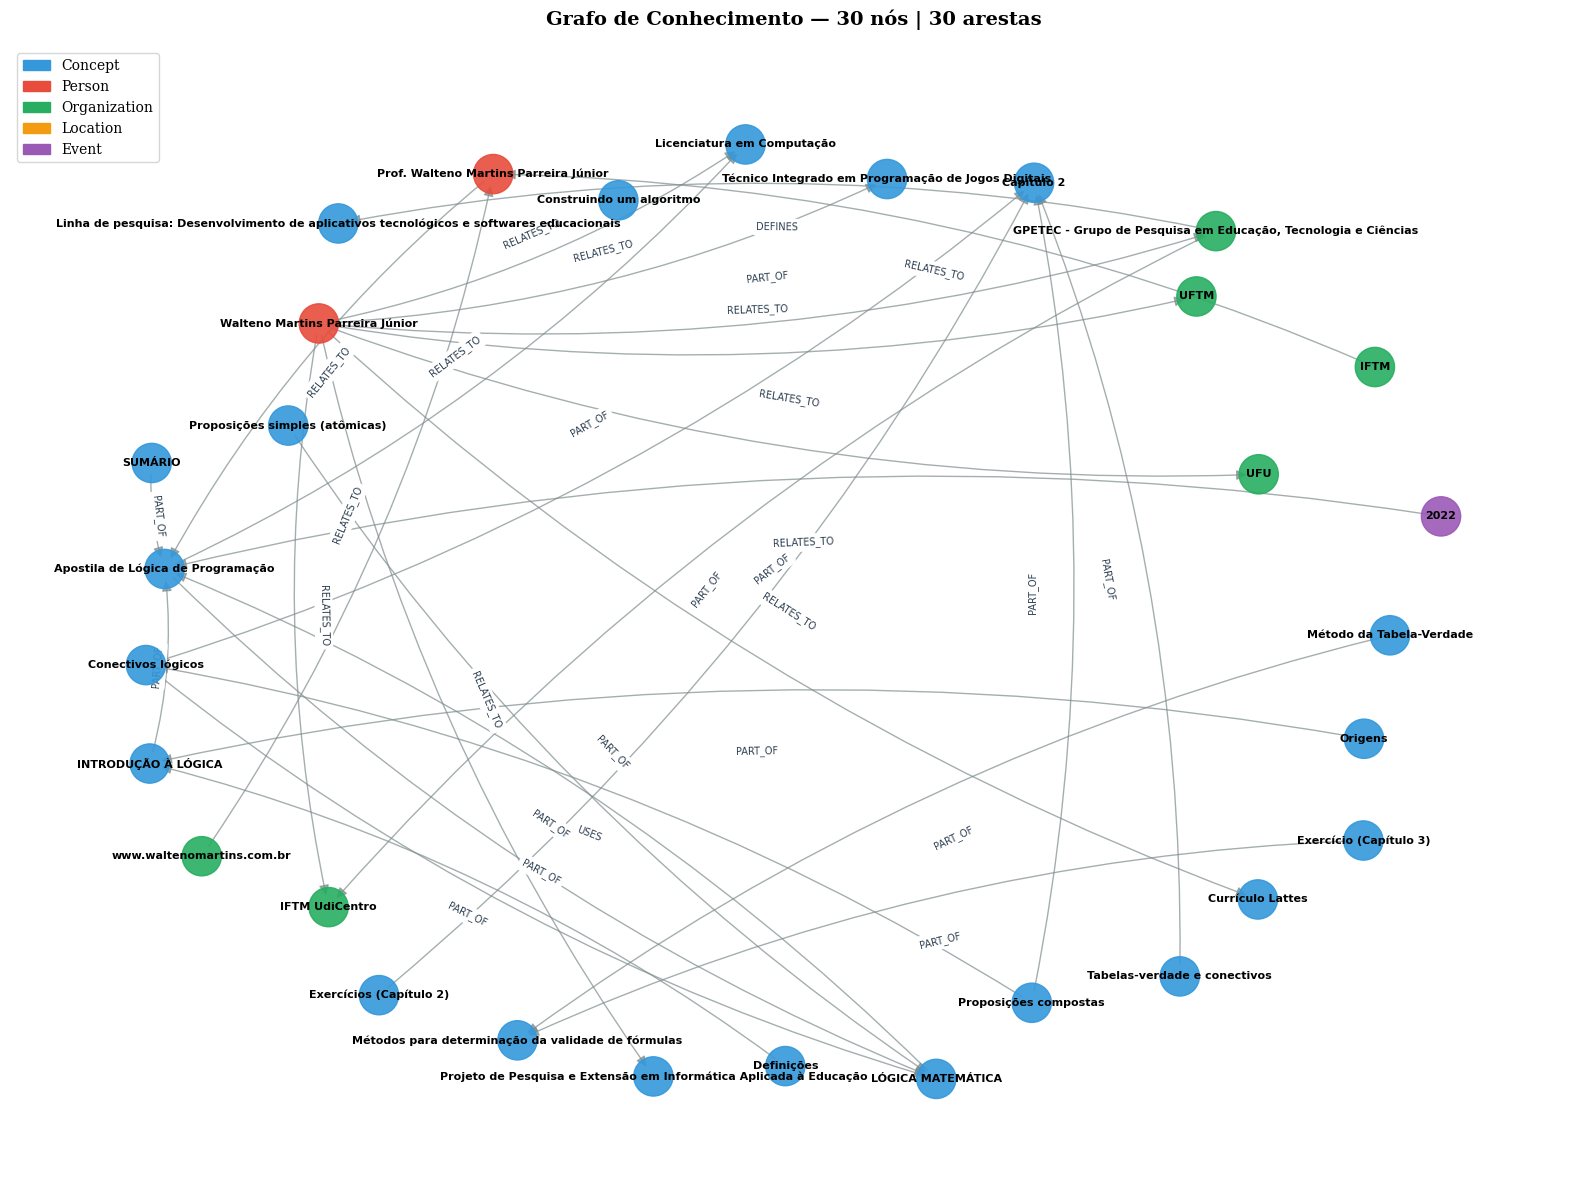

In [17]:
def visualize_knowledge_graph(max_nodes: int = 30) -> None:
    """Plota o grafo de conhecimento com layout spring e cores por tipo de entidade."""
    G = knowledge_graph.graph

    if G.number_of_nodes() == 0:
        print("Grafo vazio. Execute a ingestão primeiro.")
        return

    # Limita para visualização
    nodes_to_show = list(G.nodes())[:max_nodes]
    subG = G.subgraph(nodes_to_show)

    type_colors = {
        "Concept":      "#3498db",
        "Person":       "#e74c3c",
        "Organization": "#27ae60",
        "Location":     "#f39c12",
        "Event":        "#9b59b6",
    }

    node_colors = [
        type_colors.get(
            knowledge_graph.entities.get(n, EntityNode(n, n, "Concept")).type,
            "#95a5a6"
        )
        for n in subG.nodes()
    ]

    node_labels = {
        n: knowledge_graph.entities.get(n, EntityNode(n, n, "")).name
        for n in subG.nodes()
    }

    edge_labels = {
        (u, v): data.get("relation", "")
        for u, v, data in subG.edges(data=True)
    }

    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(subG, k=2.5, seed=42)

    nx.draw_networkx_nodes(subG, pos, node_color=node_colors,
                           node_size=800, alpha=0.9)
    nx.draw_networkx_labels(subG, pos, labels=node_labels,
                            font_size=8, font_weight="bold")
    nx.draw_networkx_edges(subG, pos, edge_color="#7f8c8d",
                           arrows=True, arrowsize=15,
                           connectionstyle="arc3,rad=0.1", alpha=0.7)
    nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels,
                                 font_size=7, font_color="#2c3e50")

    # Legenda
    legend_patches = [
        mpatches.Patch(color=c, label=t)
        for t, c in type_colors.items()
    ]
    plt.legend(handles=legend_patches, loc="upper left",
               frameon=True, fontsize=10)

    plt.title(
        f"Grafo de Conhecimento — {subG.number_of_nodes()} nós | {subG.number_of_edges()} arestas",
        fontsize=14, fontweight="bold", pad=15
    )
    plt.axis("off")
    plt.tight_layout()
    plt.show()


visualize_knowledge_graph(max_nodes=30)

## 📋 15. Resumo do Pipeline

In [ ]:
print("="*65)
print("  GRAPH RAG — RESUMO DO PIPELINE")
print("="*65)
print(f"  Modelo:          Claude Sonnet 4.6")
print(f"  Embeddings:      HuggingFace all-MiniLM-L6-v2")
print(f"  Vector Store:    InMemoryVectorStore (LangChain)")
print(f"  Orquestração:    LangGraph (StateGraph)")
print(f"  Observabilidade: LangSmith (project: {os.environ['LANGCHAIN_PROJECT']})")
print(f"  Grafo:           NetworkX DiGraph")
print("-"*65)
print(f"  Documentos carregados:  {len(docs)}")
print(f"  Chunks indexados:       {len(all_splits)}")
graph_stats = knowledge_graph.stats
print(f"  Entidades no grafo:     {graph_stats['nodes']}")
print(f"  Relações no grafo:      {graph_stats['edges']}")
print("-"*65)
print(f"  Tools do agente:")
for t in tools:
    print(f"    • {t.name}")
print("="*65)